In [ ]:
import numpy as np
from umap import UMAP
import hdbscan

# ========== LOAD DATA ==========
# Load your file with 8,192 floats per line
X_freq = np.loadtxt('./Data/kmer_frequencies_l5000_shuffled.txt', max_rows = 200_000, dtype=np.float32)

print(f"Loaded {X_freq.shape[0]} sequences")
print(f"Sum check: {X_freq[0].sum():.6f}")  # Should be ~1.0

Loaded 200000 sequences
Sum check: 1.000000


In [ ]:
# ========== UMAP ==========
# Use cosine metric (works well for frequency data, much faster than JS)
reducer = UMAP(
    n_components=32,
    metric='cosine',
    n_neighbors=15,
    min_dist=0.0,
    verbose=True
)

embedding = reducer.fit_transform(X_freq)
np.save('umap_embedding_32d.npy', embedding)

# ========== CLUSTERING ==========
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=10,
    metric='euclidean'
)
labels = clusterer.fit_predict(embedding)

np.save('cluster_labels.npy', labels)

print(f"Found {len(set(labels)) - 1} clusters")
print(f"Noise points: {(labels == -1).sum()}")

# ========== 2D VISUALIZATION ==========
reducer_2d = UMAP(
    n_components=2,
    metric='cosine',
    n_neighbors=15,
    min_dist=0.1
)
embedding_2d = reducer_2d.fit_transform(X_freq)
np.save('umap_embedding_2d.npy', embedding_2d)

/home/torben/Clustering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-17 14:34:31.024915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 14:34:31.054698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 14:34:31.831661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. Y

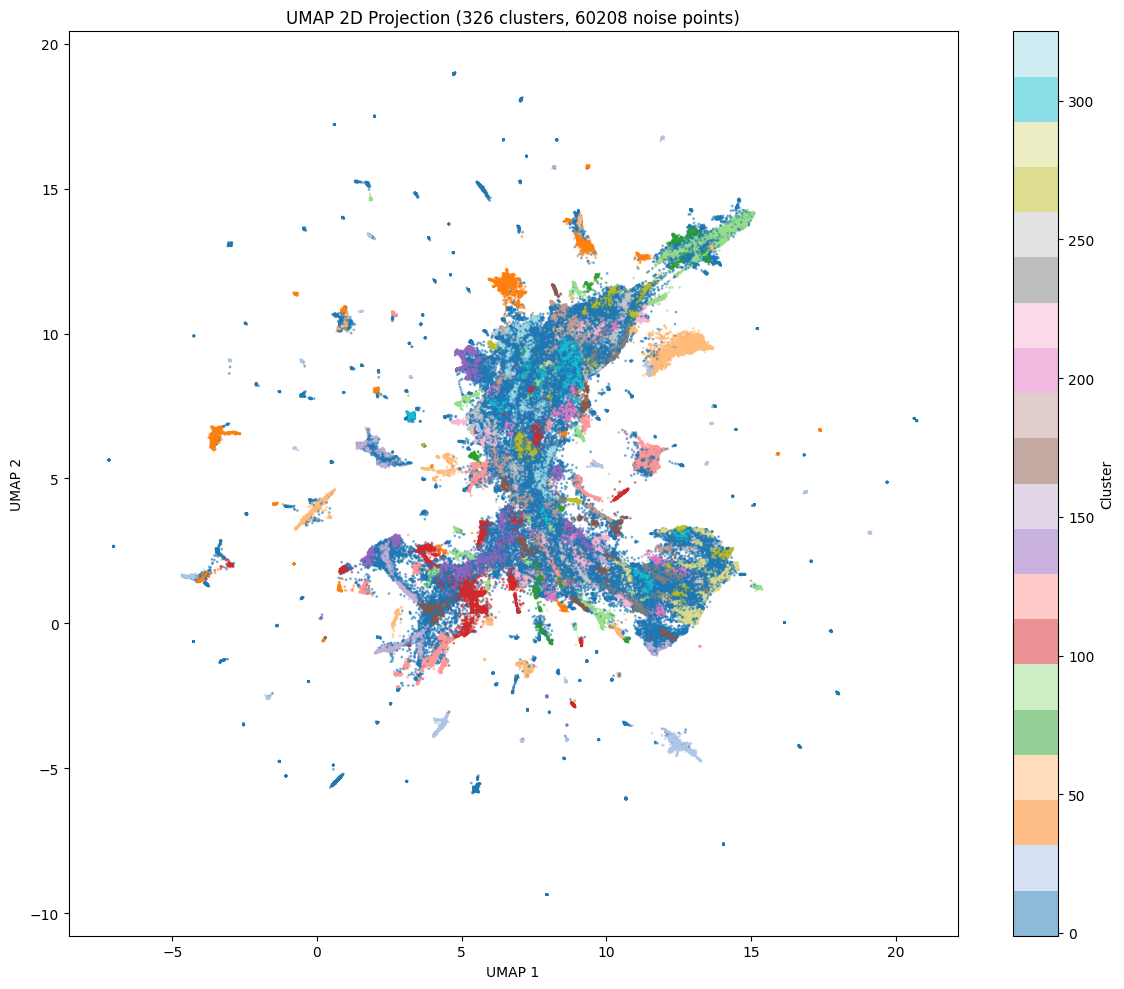

Visualization saved as umap_clusters.png


In [3]:
import numpy as np
from umap import UMAP
import hdbscan
import matplotlib.pyplot as plt

# Load the 2D embedding and cluster labels
embedding_2d = np.load('umap_embedding_2d.npy')
labels = np.load('cluster_labels.npy')

# Create figure
plt.figure(figsize=(12, 10))

# Plot points colored by cluster
# Use -1 for noise points (will be gray)
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=labels, 
    cmap='tab20',  # Good for many clusters
    s=1,  # Small point size for large datasets
    alpha=0.5
)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'UMAP 2D Projection ({len(set(labels))-1} clusters, {(labels==-1).sum()} noise points)')
plt.tight_layout()
plt.savefig('umap_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved as umap_clusters.png")

In [ ]:
# Interactive visualization with plotly (optional)
# Install with: uv add plotly pandas
import plotly.express as px
import pandas as pd

# Create dataframe for plotly
df = pd.DataFrame({
    'UMAP_1': embedding_2d[:, 0],
    'UMAP_2': embedding_2d[:, 1],
    'Cluster': labels.astype(str)
})

# Create interactive plot
fig = px.scatter(
    df, 
    x='UMAP_1', 
    y='UMAP_2', 
    color='Cluster',
    title=f'Interactive UMAP 2D Projection',
    opacity=0.5,
    hover_data={'UMAP_1': ':.2f', 'UMAP_2': ':.2f'}
)

fig.update_traces(marker=dict(size=2))

# Save as HTML (open in browser to view)
fig.write_html('umap_interactive.html')
print("Interactive plot saved as umap_interactive.html")
print("Open umap_interactive.html in your browser to explore the plot")